# Gary's Notebook
## Here, I will attempt to learn about ML and CV by doing practical hands-on experiments.

In [274]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image  # in Python3, you need to actually import Pillow. This is an import of Python2.7's PIL
from scipy import signal

In [275]:
def show_images(image_list, row=1, col=1):
    """
    Helper function. Plot multiple images into a subplot
    @param image_list: list of tuples. First element is a string(name) and second element is the image(PIL Image object)
    """
    for idx, ele in enumerate(image_list):
        plt.subplot(row, col, idx+1)
        plt.title(ele[0])
        plt.imshow(ele[1])
        plt.axis("off")

### I have a JSON file that contains all a bunch of dog pictures in various format (via Pexel API). The following block of code loads those images into memory

In [276]:
with open("../dump_1.json", "r", encoding="utf-8") as fr:
    j = json.load(fr)

# 250 images. Each image has a width of 180px and height of 130px. Will definitely need to pull more images.
photo_list = list()
for photo in j["photos"]:
    photo_list.append(photo["src"]["small"])

### Now that we have saved the image urls into a list. We use the requests library to fetch those urls and show the image

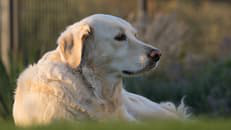

In [277]:
# Pull a random dog image
import random
response = requests.get(photo_list[random.randint(0, len(photo_list)+1)])
im = Image.open(BytesIO(response.content))
im

### Let's use NumPy to show a multi-dimensional representation of above image

In [278]:
np_im_color = np.array(im)
print(np_im_color.shape, np_im_color.dtype)

# Now, compare the matrix against a grayscale image
np_im_gray = np.array(im.convert("L"))
print(np_im_gray.shape, np_im_gray.dtype)

(130, 231, 3) uint8
(130, 231) uint8


## Graylevel transformations
### Ok, cool. So we managed to load an image into a numpy array. What can we do? Well, it turns out that we can do alot. The values in the numpy array represents the intensity of each pixel color. Now, we have a way to control the intensity of each pixel.

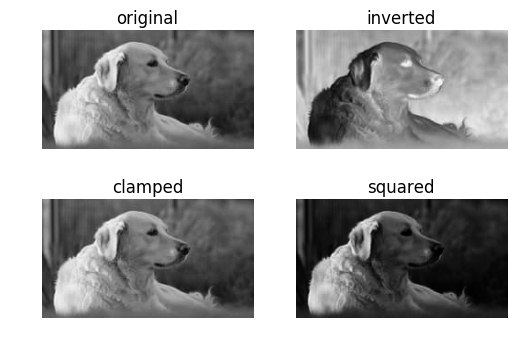

In [279]:
# APPARENTLY Images `fromarray` METHOD ONLY SUPPORTS UINT8 DATATYPES!!! REMEMBER TO TYPECAST THE ELEMENTS
im_1 = 255 - np_im_gray  # inverts the image

im_2 = (100/255)*np_im_gray + 100  # clamps values of each pixel between 100-255
# print(im_2.shape, im_2.dtype)

im_3 = 255.0*(np_im_gray/255.0)**2  # quadratic function, it increases intensity of darker colored pixels

images = [("original", Image.fromarray(np_im_gray)),
          ("inverted", Image.fromarray(im_1)),
          ("clamped", Image.fromarray(np.uint8(im_2))),
          ("squared", Image.fromarray(np.uint8(im_3)))]

show_images(images, 2, 2)

## Another useful graylevel transformation: Histogram equalization.
### This technique tries to equalize the level of intensity of each pixel value. This is usually used to increase image  contrast before processing. (Left) original image and (Right) the darker pixels are much more noticeable

[[ 187.60623802  204.84400026  211.57038863 ...,   25.38766152
    25.38766152   25.38766152]
 [ 189.14640278  204.84400026  211.57038863 ...,   31.21673409
    29.27078659   29.27078659]
 [ 187.60623802  203.95016459  210.7547862  ...,   42.82546142
    41.01607409   37.225938  ]
 ..., 
 [ 118.73745926  122.86210511  122.86210511 ...,   98.79703084   95.4324446
    92.01802296]
 [ 110.0623393   114.36836934  118.73745926 ...,   95.4324446    92.01802296
    92.01802296]
 [ 110.0623393   114.36836934  118.73745926 ...,   95.4324446    92.01802296
    92.01802296]]


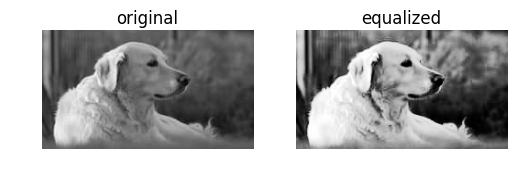

In [280]:
im_hist, bins = np.histogram(np_im_gray.flatten(), 256, normed=True)  # get the histogram of our gray-scaled image
cdf = im_hist.cumsum()  # cumulative distribution function

cdf = 255*cdf/cdf[-1]  # normalize
# cdf.max()
# cdf = (cdf-min(cdf))/(max(cdf)-min(cdf))

im_eqlz = np.interp(np_im_gray.flatten(), bins[:-1], cdf)
im_eqlz = im_eqlz.reshape(np_im_gray.shape)
images = [("original", np_im_gray), ("equalized", im_eqlz)]

show_images(images, 1, 2)
print(im_eqlz)

### Ok, lets see what happens if we apply equalization to a *DARKER* image. Let's use the image with "squared" function applied to it as our original image and apply equalization to it. We would expect the resulting image to be lighter, hence "equalization."

[[ 186.97387698  204.87335216  211.83269396 ...,   28.56414664
    28.56414664   28.56414664]
 [ 188.50562832  204.87335216  211.83269396 ...,   33.61920966
    31.85603161   31.85603161]
 [ 186.97387698  203.90229842  210.20729271 ...,   44.14728361
    42.42655405   38.87961599]
 ..., 
 [ 119.57127039  125.32818042  125.32818042 ...,   99.94342862
    97.61166243   95.29811512]
 [ 111.84163457  115.09075531  119.57127039 ...,   97.61166243
    95.29811512   95.29811512]
 [ 111.84163457  115.09075531  119.57127039 ...,   97.61166243
    95.29811512   95.29811512]]


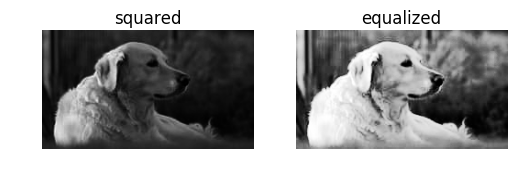

In [281]:
im_hist, bins = np.histogram(im_3.flatten(), 256, normed=True)  # get the histogram of our "squared" image
cdf = im_hist.cumsum()  # cumulative distribution function

cdf = 255*cdf/cdf[-1]  # normalize
# cdf.max()
# cdf = (cdf-min(cdf))/(max(cdf)-min(cdf))

im_eqlz = np.interp(im_3.flatten(), bins[:-1], cdf)
im_eqlz = im_eqlz.reshape(im_3.shape)

images = [("squared", im_3), ("equalized", im_eqlz)]
show_images(images, 1, 2)
print(im_eqlz)  

# Notice that the pixel values for the equalized image are slightly different than from the image above

# *Convolution*: Apparently this is a very important concept in image processing.
## Convolution, in image processing, is the process of applying a *kernel*, or filter, to every pixel in an image and creating a new resulting image. The size of a kernel is arbitrary, but they are usually 3x3. We convolve images with filters to smooth, sharpen, intensify, or enhance it.
### Let's start with something very simple and play with the identity kernel. If we did this operation crrectly, the convolved image should be exact same as the original image. (We can show this by outputting the image matrix.)

In [282]:
id_kernal = np.array([[0,0,0], [0,1,0], [0,0,0]])
h = signal.convolve2d(np_im_gray, id_kernal, mode="same")
np.array_equal(np_im_gray, h)  # verify whether two images are equal

True

### Nice. We can do convolution now. Let's create several other interesting filter. One that blurs and one that sharpens edges. And then lets try using 5x5 filters and compare the output. Go.

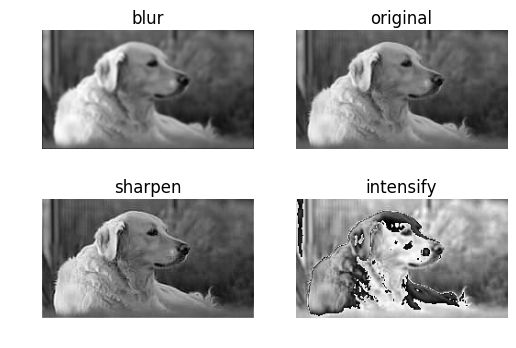

In [283]:
original = Image.fromarray(np_im_gray)
blur_kernel = np.ones((3,3))/9  # 3x3 averaging filter
blur_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, blur_kernel, mode="same")))

intensity_kernel = np.array([[0,0,0], [0,2,0], [0,0,0]])
intensity_im = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, intensity_kernel, mode="same")))

sharpen_kernel = intensity_kernal - blur_kernal
sharpen_im = Image.fromarray(signal.convolve2d(np_im_gray, sharpen_kernel, mode="same"))
images = [("blur", blur_im), ("original", original), ("sharpen", sharpen_im), ("intensify", intensity_im)]

show_images(images, 2, 2)

### Special note on the averaging filter: Apparently a Guassian filter does a better job. Let's check it out.

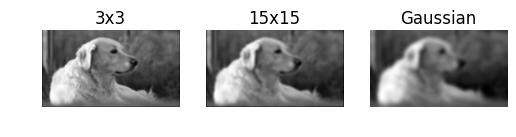

In [284]:
from scipy.ndimage import filters

# second argument is the standard deviation. As STD goes up, the "bluriness" of the image also increases
gauss_im = Image.fromarray(filters.gaussian_filter(np_im_gray, 3))

blur_kernel_2 = np.ones((5,5))/(5**2)  # try adjusting the filter size and value
blur_im_2 = Image.fromarray(np.uint8(signal.convolve2d(np_im_gray, blur_kernel_2, mode="same")))

show_images([("3x3", blur_im), ("15x15", blur_im_2), ("Gaussian", gauss_im)], 1, 3)

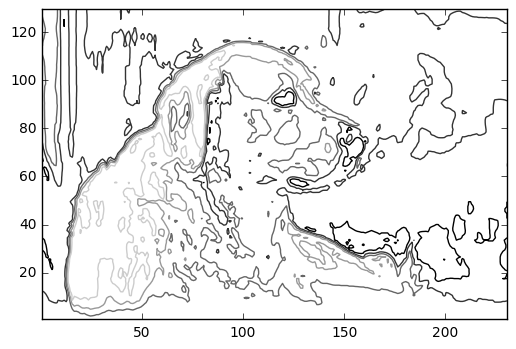

In [285]:
from pylab import gray, contour
gray()
contour(im.convert("L"), origin="image")